# Analysis of dynamical polarizability of $N_2$ in the linear response formalism

We analyze the computation of the dynamical polarizabilityi inside the linear response formalism.

The aim of this notebook is to:

* compute the Casida matrix associated to the highest value of virtual orbitals. 
* build the matrices associated to a lower number of virtual orbitals (by extracting its elements from the highest one) and discuss the rate of convergence of the statical polarizability to the reference value (formerly computed by including an explicit electric field). 
* evaluate the dynamical polarizability spectrum and discuss its stability in function of the number of virtual orbitals considered.  

In [1]:
%autosave 0
from BigDFT import Logfiles as lf
from BigDFT import Calculators as C
from futile import Yaml
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack
import sys
sys.path.insert(0,'../')
import Routine as R
outputpath = 'linear-response/'

Autosave disabled


First of all we compute the coupling matrix

In [2]:
inp0 = {'dft' : 
        {'hgrids': 0.40,
         'gnrm_cv' : 1e-8,
         'itermax' : 100,
         'inputpsiid': 2},
        'tddft':{'tddft_approach': 'full'},
        'posinp': 'N2_posinp.xyz'}
Yaml.dump(inp0,outputpath + 'default.yaml')

In [3]:
virtMax = 303 # 279 for Rmult = 9.0 and 303 for Rmult = 7.0
rVal = 7.0 # calculation performed for rVal = 7.0 and 9.0 to check the stability of the spectrum

In [4]:
inp={'dft':
     {'rmult': [rVal, 9.0],
      'itermax_virt' : 1},
     'output': {
      'orbitals' : 'No',
      'verbosity' : 3}, 
     'radical': 'Rmult_'+str(rVal)}

inp['dft']['norbv'] = -virtMax
inpname = 'NumVirt_'+str(virtMax)
Yaml.dump(inp,outputpath + inpname + '.yaml')

We execute the input file and copy the coupling matrix and transition dipoles in the "TDDFT-Results" folder with the name coupling_matrix_n and transition_dipoles_n

In [5]:
code=C.SystemCalculator(omp=2,mpi=4)
%cd $outputpath
code.run(name='NumVirt_'+str(virtMax),skip=True,outdir='./log/')
%cd ../

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/linear-response
Executing command:  mpirun -np 4 $BIGDFT_ROOT/bigdft -n NumVirt_303 -d ./log/ -s Yes
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


Read the dipoles and coupling matrix (for Rmult = 7.0)

In [6]:
%cd $outputpath
dpath = 'log/TDDFT-Results/transition_dipoles_303.txt'
dipoles = np.loadtxt(dpath)
cpath = 'log/TDDFT-Results/coupling_matrix_303.txt'
C = np.loadtxt(cpath)
%cd ..

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/linear-response
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


We observe that $C$ is a symmetric matrix

In [7]:
np.allclose(C,C.T,atol=1.e-12)

True

### Analysis of the statical polarizability for Rmult = 7.0

We discuss the convergence of the static polarizability to its reference value obtained with the explicit electric field.
We make use of the "extract_subset" routine to build coupling matrix and dipoles corresponding to a given set of virtual orbitals.

In [9]:
virtMax_rmult7 = 303

In [9]:
alphaX = []
alphaY = []
alphaZ = []
virt = [16, 32, 48, 64, 80, 96, 112, 128, 160, 224, 256, 282, virtMax_rmult7]
for nind,nval in enumerate(virt):
    C_ext,dipoles_ext=R.extract_subset([5],[virtMax_rmult7],C,dipoles,[nval])
    E2,C_E2=np.linalg.eigh(C_ext)
    sumx = 0.0
    sumy = 0.0
    sumz = 0.0
    for i,e in enumerate(E2):
        a = np.dot(C_E2.T[i],dipoles_ext)
        sumx+=2.0*a[0]*a[0]/e
        sumy+=2.0*a[1]*a[1]/e
        sumz+=2.0*a[2]*a[2]/e
    alphaX.append(sumx)
    alphaY.append(sumy)
    alphaZ.append(sumz)
print alphaX
#print alphaY #to check if it equal to alphaX, ok!
print alphaZ

[7.3652950119485476, 9.6242684396559124, 9.8590060344400037, 9.9364599831261238, 10.339951031264928, 10.482367211649217, 10.653716399235877, 10.674905928324078, 10.681847969511644, 10.813931701943329, 10.816648493212673, 10.817183972186124, 10.817482977440704]
[11.059355520654851, 13.342467191524742, 14.110484711878737, 14.112372059335186, 14.481305891704139, 14.835325601281776, 15.128965766060759, 15.130305079916655, 15.158499711887121, 15.449218616028533, 15.463779379233685, 15.494289416258189, 15.494538708805711]


In [10]:
alphaX_ref = 10.87
alphaZ_ref = 15.736

In [11]:
alphaX_norm = [i/alphaX_ref for i in alphaX]
alphaZ_norm = [i/alphaZ_ref for i in alphaZ]

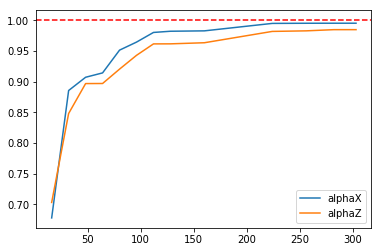

In [12]:
%matplotlib inline
plt.plot(virt,alphaX_norm,label='alphaX')
plt.axhline(y=1.0, color='r', linestyle='--')
plt.plot(virt,alphaZ_norm,label='alphaZ')
plt.legend()
plt.show()

To check the correctness of the procedure for the construcion of the coupling matrix (given the one with the highest number of virtual orbitals) we compare some of the result obtained above with the ones build in terms of the true coupling matrix computed with 16 and 32 virtual orbitals.

In [33]:
%cd $outputpath
dpath = 'log/TDDFT-Results/transition_dipoles_16.txt'
dipoles_16 = np.loadtxt(dpath)
cpath = 'log/TDDFT-Results/coupling_matrix_16.txt'
C_16 = np.loadtxt(cpath)
dpath = 'log/TDDFT-Results/transition_dipoles_32.txt'
dipoles_32 = np.loadtxt(dpath)
cpath = 'log/TDDFT-Results/coupling_matrix_32.txt'
C_32 = np.loadtxt(cpath)
%cd ..

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/linear-response
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


In [34]:
alphaX_16 = 0.0
alphaZ_16 = 0.0
E2,C_E2=np.linalg.eigh(C_16)
for i,e in enumerate(E2):
    a = np.dot(C_E2.T[i],dipoles_16)
    alphaX_16+=2.0*a[0]*a[0]/e
    alphaZ_16+=2.0*a[2]*a[2]/e
print alphaX_16, alphaZ_16

alphaX_32 = 0.0
alphaZ_32 = 0.0
E2,C_E2=np.linalg.eigh(C_32)
for i,e in enumerate(E2):
    a = np.dot(C_E2.T[i],dipoles_32)
    alphaX_32+=2.0*a[0]*a[0]/e
    alphaZ_32+=2.0*a[2]*a[2]/e
print alphaX_32, alphaZ_32

7.36529492352 11.0593555809
9.62426842818 13.3424672819


Results agree with those obtained by the application of the "extract_subset" routine.

### Dynamical polarizability in the adiabatic case for Rmult=7.0

We plot the imaginary part of (minus) $A(\omega_0)$ using the coupling matrix e transition dipoles in function of the number of virtual orbitals considered in the computation. In particular we want to compare results for numVirt = 64,128,virtMax

In [24]:
npoint = 1000
eta = 1.0e-2
omega = []
A = []
#virt = [64,128,virtMax_rmult7] # for plot
virt = [32,64,128,192,256,virtMax_rmult7] # for writing the dictionary on file
for ii,nVal in enumerate(virt):
    C_ext,dipoles_ext=R.extract_subset([5],[virtMax_rmult7],C,dipoles,[nVal])
    E2,C_E2=np.linalg.eigh(C_ext)
    omegaMax = np.sqrt(E2[-1]) #square root of the highest eigenvalues
    print 'lenE2', len(E2), 'omegaMax', omegaMax
    omega.append(np.linspace(0.0,omegaMax,npoint))
    A_nVirt = np.zeros(npoint, dtype=complex)
    fE = []
    for i in range(len(E2)):
        fE.append(np.dot(C_E2.T[i],dipoles_ext[:,2]))
    for ind,o in enumerate(omega[ii]):
        s = 0.0
        for i,e in enumerate(E2):
            s+=fE[i]**2/(complex(o,2*eta)**2-e)
        A_nVirt[ind] = s
    A.append(-np.imag(A_nVirt))

lenE2 320 omegaMax 1.35374670349
lenE2 640 omegaMax 1.56325137367
lenE2 1280 omegaMax 1.83601135465
lenE2 1920 omegaMax 2.10867642813
lenE2 2560 omegaMax 2.30125811398
lenE2 3030 omegaMax 2.46915758956


In [25]:
omega_ev = []
for i in range(len(omega)):
    omega_ev.append(27.211*omega[i])

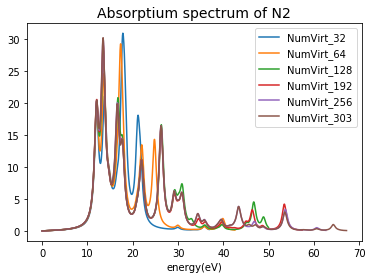

In [26]:
%matplotlib inline
for i in range(len(virt)):
    plt.plot(omega_ev[i],A[i],label='NumVirt_'+str(virt[i]))
plt.legend()
plt.xlabel('energy(eV)')
plt.title('Absorptium spectrum of N2', fontsize=14)
plt.show()

In [28]:
AbSpectrum = {}
for ind,na in enumerate(virt):
    print
    AbSpectrum[na] = {'omega' : omega_ev[ind].tolist(), 'spectrum' : A[ind].tolist()}
filename = outputpath+'log/spectrum_rmult7.0.yaml '
#Yaml.dump(AbSpectrum,filename)

### Stability of the results vs. size of the simultation box

We analyze the convergence of the statical polarizability to the reference value for Rmult = 9.0

In [29]:
%cd $outputpath
dpath = 'log/TDDFT-Results/transition_dipoles_rmult=9.0_279.txt'
dipoles = np.loadtxt(dpath)
cpath = 'log/TDDFT-Results/coupling_matrix_rmult=9.0_279.txt'
C = np.loadtxt(cpath)
%cd ..

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/linear-response
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


In [30]:
virtMax_rmult9 = 279

In [53]:
alphaX = []
alphaY = []
alphaZ = []
virt = [16, 32, 48, 64, 80, 96, 112, 128, 160, 224, 256, virtMax_rmult9]
for nind,nval in enumerate(virt):
    C_ext,dipoles_ext=R.extract_subset([5],[virtMax_rmult9],C,dipoles,[nval])
    E2,C_E2=np.linalg.eigh(C_ext)
    sumx = 0.0
    sumy = 0.0
    sumz = 0.0
    for i,e in enumerate(E2):
        a = np.dot(C_E2.T[i],dipoles_ext)
        sumx+=2.0*a[0]*a[0]/e
        sumy+=2.0*a[1]*a[1]/e
        sumz+=2.0*a[2]*a[2]/e
    alphaX.append(sumx)
    alphaY.append(sumy)
    alphaZ.append(sumz)
print alphaX
#print alphaY #to check if it equal to alphaX, ok!
print alphaZ

[6.4626561123892055, 8.4354956508710313, 8.5663026715236121, 8.8642454775988888, 9.7611222584797162, 9.8721503816250493, 10.059414788310804, 10.10099456101829, 10.171737615659101, 10.631972230523898, 10.643056253792423, 10.643700998141032]
[6.462656112388987, 8.4354956508708288, 8.5663026715234416, 8.8642454775987005, 9.7611222584795581, 9.8721503816248806, 10.05941478831066, 10.10099456101814, 10.171737615658966, 10.631972230523809, 10.643056253792249, 10.643701005208033]
[9.7087505567632615, 11.882177668613133, 12.411397249705038, 12.451605332609098, 13.813491067570668, 13.814027204686461, 14.315673257169275, 14.341833122951826, 14.546232505676423, 15.070483556366511, 15.074267132648856, 15.092620758654903]


In [54]:
alphaX_ref = 10.87
alphaZ_ref = 15.736

In [55]:
alphaX_norm = [i/alphaX_ref for i in alphaX]
alphaZ_norm = [i/alphaZ_ref for i in alphaZ]

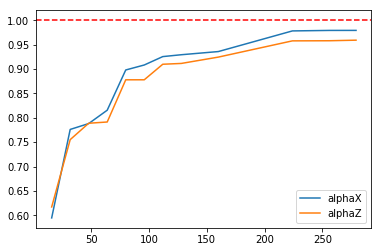

In [56]:
%matplotlib inline
plt.plot(virt,alphaX_norm,label='alphaX')
plt.axhline(y=1.0, color='r', linestyle='--')
plt.plot(virt,alphaZ_norm,label='alphaZ')
plt.legend()
plt.show()

We compare the absorption spectrum

In [45]:
%cd $outputpath
dpath = ['log/TDDFT-Results/transition_dipoles_303.txt','log/TDDFT-Results/transition_dipoles_rmult=9.0_279.txt']
cpath = ['log/TDDFT-Results/coupling_matrix_303.txt','log/TDDFT-Results/coupling_matrix_rmult=9.0_279.txt']
npoint = 1000
eta = 1.0e-2
omega = []
A = []

for ii in range(len(dpath)):
    dipoles = np.loadtxt(dpath[ii])
    C = np.loadtxt(cpath[ii])
    E2,C_E2=np.linalg.eigh(C)
    omegaMax = np.sqrt(E2[-1])
    print 'lenE2', len(E2), 'omegaMax', omegaMax
    omega.append(np.linspace(0.0,omegaMax,npoint))
    A_nVirt = np.zeros(npoint, dtype=complex)
    fE = []
    for i in range(len(E2)):
        fE.append(np.dot(C_E2.T[i],dipoles[:,2]))
    for ind,o in enumerate(omega[ii]):
        s = 0.0
        for i,e in enumerate(E2):
            s+=fE[i]**2/(complex(o,2*eta)**2-e)
        A_nVirt[ind] = s
    A.append(-np.imag(A_nVirt))
%cd ..

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/linear-response
lenE2 3030 omegaMax 2.46915758956
lenE2 2790 omegaMax 1.92260078949
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


In [46]:
omega_ev = []
for i in range(len(omega)):
    omega_ev.append(27.211*omega[i])

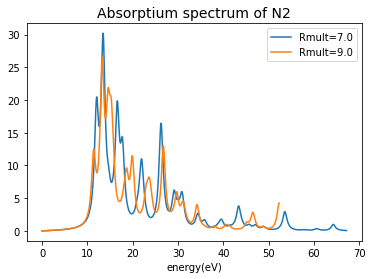

In [48]:
%matplotlib inline
lab = ['7.0','9.0']
for i in range(len(dpath)):
    plt.plot(omega_ev[i],A[i],label='Rmult='+lab[i])
plt.legend()
plt.xlabel('energy(eV)')
plt.title('Absorptium spectrum of N2', fontsize=14)
plt.show()

We write the spectrum for rmult = 9.0 on a dictionary

In [31]:
npoint = 1000
eta = 1.0e-2
omega = []
A = []
#virt = [64,128,virtMax_rmult7] # for plot
virt = [32,64,128,192,256,virtMax_rmult9] # for writing the dictionary on file
for ii,nVal in enumerate(virt):
    C_ext,dipoles_ext=R.extract_subset([5],[virtMax_rmult9],C,dipoles,[nVal])
    E2,C_E2=np.linalg.eigh(C_ext)
    omegaMax = np.sqrt(E2[-1]) #square root of the highest eigenvalues
    print 'lenE2', len(E2), 'omegaMax', omegaMax
    omega.append(np.linspace(0.0,omegaMax,npoint))
    A_nVirt = np.zeros(npoint, dtype=complex)
    fE = []
    for i in range(len(E2)):
        fE.append(np.dot(C_E2.T[i],dipoles_ext[:,2]))
    for ind,o in enumerate(omega[ii]):
        s = 0.0
        for i,e in enumerate(E2):
            s+=fE[i]**2/(complex(o,2*eta)**2-e)
        A_nVirt[ind] = s
    A.append(-np.imag(A_nVirt))

lenE2 320 omegaMax 1.23490452336
lenE2 640 omegaMax 1.35957659044
lenE2 1280 omegaMax 1.53623398023
lenE2 1920 omegaMax 1.72681211035
lenE2 2560 omegaMax 1.83111462488
lenE2 2790 omegaMax 1.92260078949


In [32]:
omega_ev = []
for i in range(len(omega)):
    omega_ev.append(27.211*omega[i])

In [33]:
AbSpectrum = {}
for ind,na in enumerate(virt):
    print
    AbSpectrum[na] = {'omega' : omega_ev[ind].tolist(), 'spectrum' : A[ind].tolist()}
filename = outputpath+'log/spectrum_rmult9.0.yaml '
#Yaml.dump(AbSpectrum,filename)